In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def create_sim(user_unknown, base_rates, lower_threshold=0.0):
    '''

    Create the similarity vector between user_unknown and each user in base_rates using cosine similarity. The items not rated by any of the two users are ignored.
    (Consider improve this function using numpy built-in functions)

    :param user_unknown:
    :param base_rates:
    :return:
    '''
    user_sim = np.array([])

    for user in range(len(base_rates)):
        sumx = 0
        sumy = 0
        sumxy = 0

        for idx in range(len(base_rates[user])):
            if not np.isnan(user_unknown[idx]) and not np.isnan(base_rates[user][idx]):
                sumx += user_unknown[idx] * user_unknown[idx]
                sumy += base_rates[user][idx] * base_rates[user][idx]
                sumxy += user_unknown[idx] * base_rates[user][idx]

        new_sim = sumxy/(np.sqrt(sumx)*np.sqrt(sumy))
        if 0 <= new_sim < lower_threshold:
            user_sim = np.append(user_sim, lower_threshold)
        elif 0 > new_sim > -lower_threshold:
            user_sim = np.append(user_sim, -lower_threshold)
        else:
            user_sim = np.append(user_sim, new_sim)

    return user_sim

# Weighted mean

In [19]:
def infer_rate_mean(item_nb, user_sim, base_rates):
    '''
    Uses the ponderated mean to infer the predicted rate of the user.

    :param item_nb:
    :param user_sim:
    :param base_rates:
    :return:
    '''
    sum_sim = 0
    rate = 0
    for user in range(len(base_rates)):
        if base_rates[user, item_nb] is not np.nan:
            sum_sim += np.abs(user_sim[user])
            rate += user_sim[user] * base_rates[user, item_nb]

    return rate/sum_sim


def pipeline_mean(item_nb, base_rates, user_unknown):
    user_sim = create_sim(user_unknown, base_rates)
    rate_mean = infer_rate_mean(item_nb, user_sim, base_rates)
    return rate_mean

def compute_plot_mean(sane_rates, user_unknown, malicious, item_nb, range=20):
    final_rate_mean = np.array([])
    mal_vals_to_test = np.arange(-range, range, int(range/10))

    sane_prediction = pipeline_mean(item_nb, np.array(sane_rates), user_unknown)


    for mal_rate in mal_vals_to_test:
        malicious[item_nb] = mal_rate
        base_rates = np.vstack([sane_rates, malicious])

        curr_rate_mean = pipeline_mean(item_nb, base_rates, user_unknown)
        final_rate_mean = np.append(final_rate_mean, curr_rate_mean)

    plt.hlines(sane_prediction, -range, range, label='Sane', linestyles='dashed')
    plt.plot(mal_vals_to_test, final_rate_mean, label='Mean')
    plt.xlabel('Rate of the malicious user')
    plt.ylabel('Prediction for the new user')
    plt.legend()
    return plt


## Weighted mean on normal case

In [20]:
user1 = [-5, -4, -5, 4, 7, 6]
user2 = [-2, -1, -1, 3, 2, 5]
user3 = [-3, -5, -6, 4, 3, 2]
user4 = [1, 2, 1, -1, 1, -4]
user5 = [4, 7, 5, -4, -8, -3]
user6 = [5, 5, 2, -4, -2, -1]

user_unknown = [3, 2, 7, -1, -3, np.nan]

malicious = [3, np.nan, np.nan, np.nan, np.nan, -7]


base_rates = np.array([user1, user2, user3, user4, user5, user6, malicious])

sane_rates = [user1, user2, user3, user4, user5, user6]

In [21]:
rate_mean = pipeline_mean(5, base_rates, user_unknown)
print(f'rate_mean: {rate_mean}')


rate_mean: -4.139614854223902


<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

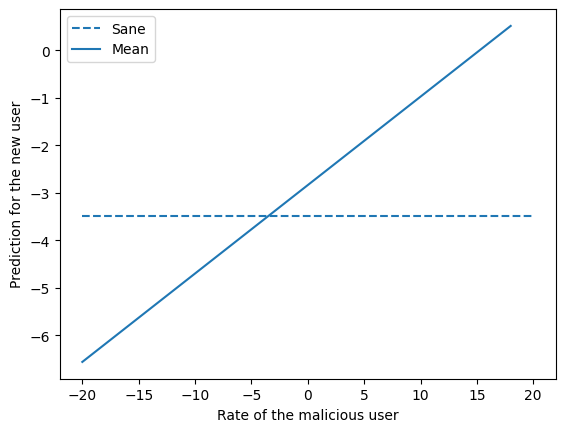

In [22]:
compute_plot_mean(sane_rates, user_unknown, malicious, 5)

## Weighted mean on edge case

In [23]:
user1_2 = [-1, 1, -5]
user2_2 = [2, -2, -1]
user3_2 = [3, -3, -1]
user4_2 = [-4, 4, -2]
user5_2 = [5, -5, -2]
user6_2 = [1, -1, 1]

user_unknown2 = [1, 1, np.nan]

malicious2 = [1, 1, np.nan]

sane_rates2 = np.array([user1_2,user2_2,user3_2,user4_2,user5_2,user6_2])

/tmp/ipykernel_15476/940821144.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return rate/sum_sim


<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

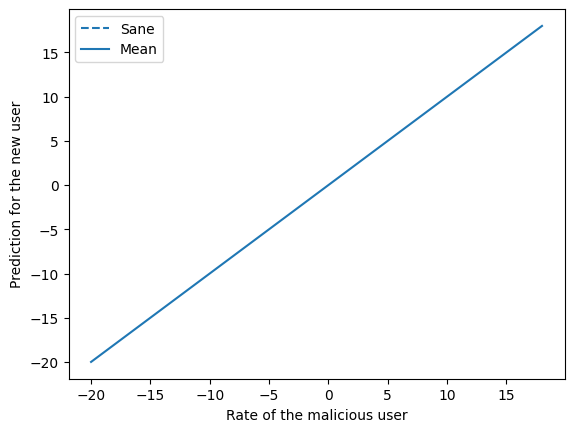

In [24]:
compute_plot_mean(sane_rates2, user_unknown2, malicious2, 2)

# Weighted Median

In [25]:
def infer_rate_median(item_nb, user_sim, base_rates):

    # Zip weights and rates
    weights_rates = np.stack([user_sim, base_rates[:,item_nb]], axis=1)

    print(f'weights_rates before inversion: {weights_rates}')

    # Inverse rates and weights for negative weights
    weights_rates = np.apply_along_axis(lambda arr: arr if arr[0] >= 0 else -arr, 1, weights_rates)

    print(f'weights_rates after inversion: {weights_rates}')

    # Sort by rates
    sorted_list = weights_rates[np.argsort(weights_rates[:,1])]

    print(f'sorted_list: {sorted_list}')

    # Remove nans
    clean_array = sorted_list[~np.isnan(sorted_list).any(axis=1)]

    # Sum the weights of the remaining entries
    sum_weights = np.sum(clean_array[:,0])

    # Accumulate the weights and stopping when reaching the half of the sum
    weights_acc = 0
    for user in clean_array:

        weights_acc += user[0]
        if weights_acc > sum_weights/2:
            return user[1]


    return None

def pipeline_median(item_nb, base_rates, user_unknown, lower_threshold=0.0):
    user_sim = create_sim(user_unknown, base_rates, lower_threshold)
    rate_mean = infer_rate_median(item_nb, user_sim, base_rates)
    return rate_mean

def compute_plot_median(sane_rates, user_unknown, malicious, item_nb, lower_threshold=0.0, range=20):
    final_rate_median = np.array([])
    mal_vals_to_test = np.arange(-range, range, int(range/10))

    sane_prediction = pipeline_median(item_nb, np.array(sane_rates), user_unknown, lower_threshold)


    for mal_rate in mal_vals_to_test:
        malicious[item_nb] = mal_rate
        base_rates = np.vstack([sane_rates, malicious])

        curr_rate_median = pipeline_median(item_nb, base_rates, user_unknown, lower_threshold=lower_threshold)
        final_rate_median = np.append(final_rate_median, curr_rate_median)

        print(f'For mal_rate: {mal_rate}, curr_rate_median: {curr_rate_median}')
        print('-------------------------------------')


    plt.hlines(sane_prediction, -range, range, label='Sane', linestyles='dashed')
    plt.plot(mal_vals_to_test, final_rate_median, label='Median')
    plt.xlabel('Rate of the malicious user')
    plt.ylabel('Prediction for the new user')
    plt.legend()
    return plt

weights_rates before inversion: [[-0.85462619  6.        ]
 [-0.64888568  5.        ]
 [-0.89475404  2.        ]
 [ 0.5        -4.        ]
 [ 0.80445045 -3.        ]
 [ 0.67129586 -1.        ]]
weights_rates after inversion: [[ 0.85462619 -6.        ]
 [ 0.64888568 -5.        ]
 [ 0.89475404 -2.        ]
 [ 0.5        -4.        ]
 [ 0.80445045 -3.        ]
 [ 0.67129586 -1.        ]]
sorted_list: [[ 0.85462619 -6.        ]
 [ 0.64888568 -5.        ]
 [ 0.5        -4.        ]
 [ 0.80445045 -3.        ]
 [ 0.89475404 -2.        ]
 [ 0.67129586 -1.        ]]
weights_rates before inversion: [[ -0.85462619   6.        ]
 [ -0.64888568   5.        ]
 [ -0.89475404   2.        ]
 [  0.5         -4.        ]
 [  0.80445045  -3.        ]
 [  0.67129586  -1.        ]
 [  1.         -20.        ]]
weights_rates after inversion: [[  0.85462619  -6.        ]
 [  0.64888568  -5.        ]
 [  0.89475404  -2.        ]
 [  0.5         -4.        ]
 [  0.80445045  -3.        ]
 [  0.67129586  -1.    

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

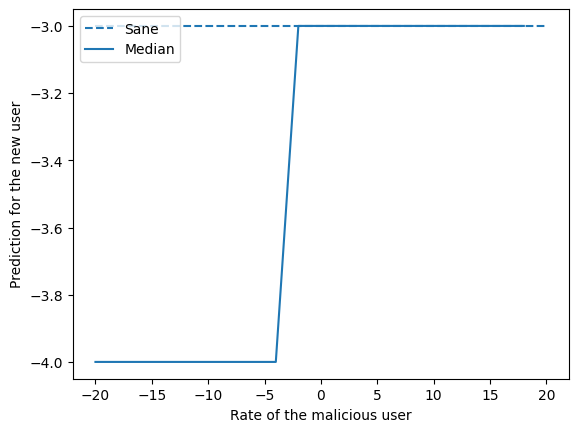

In [26]:
compute_plot_median(sane_rates, user_unknown, malicious, 5, lower_threshold=0.0)

weights_rates before inversion: [[ 0. -5.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -2.]
 [ 0. -2.]
 [ 0.  1.]]
weights_rates after inversion: [[ 0. -5.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -2.]
 [ 0. -2.]
 [ 0.  1.]]
sorted_list: [[ 0. -5.]
 [ 0. -2.]
 [ 0. -2.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]]
weights_rates before inversion: [[  0.  -5.]
 [  0.  -1.]
 [  0.  -1.]
 [  0.  -2.]
 [  0.  -2.]
 [  0.   1.]
 [  1. -20.]]
weights_rates after inversion: [[  0.  -5.]
 [  0.  -1.]
 [  0.  -1.]
 [  0.  -2.]
 [  0.  -2.]
 [  0.   1.]
 [  1. -20.]]
sorted_list: [[  1. -20.]
 [  0.  -5.]
 [  0.  -2.]
 [  0.  -2.]
 [  0.  -1.]
 [  0.  -1.]
 [  0.   1.]]
For mal_rate: -20, curr_rate_median: -20.0
-------------------------------------
weights_rates before inversion: [[  0.  -5.]
 [  0.  -1.]
 [  0.  -1.]
 [  0.  -2.]
 [  0.  -2.]
 [  0.   1.]
 [  1. -18.]]
weights_rates after inversion: [[  0.  -5.]
 [  0.  -1.]
 [  0.  -1.]
 [  0.  -2.]
 [  0.  -2.]
 [  0.   1.]
 [  1. -18.]]
sorted_list: [[  1. -18.]
 [  0.  -5.]
 [  

/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

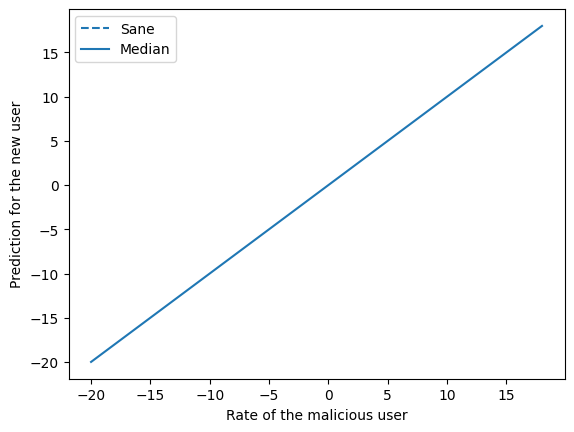

In [27]:
compute_plot_median(sane_rates2, user_unknown2, malicious2, 2)

weights_rates before inversion: [[ 0.3 -5. ]
 [ 0.3 -1. ]
 [ 0.3 -1. ]
 [ 0.3 -2. ]
 [ 0.3 -2. ]
 [ 0.3  1. ]]
weights_rates after inversion: [[ 0.3 -5. ]
 [ 0.3 -1. ]
 [ 0.3 -1. ]
 [ 0.3 -2. ]
 [ 0.3 -2. ]
 [ 0.3  1. ]]
sorted_list: [[ 0.3 -5. ]
 [ 0.3 -2. ]
 [ 0.3 -2. ]
 [ 0.3 -1. ]
 [ 0.3 -1. ]
 [ 0.3  1. ]]
weights_rates before inversion: [[  0.3  -5. ]
 [  0.3  -1. ]
 [  0.3  -1. ]
 [  0.3  -2. ]
 [  0.3  -2. ]
 [  0.3   1. ]
 [  1.  -20. ]]
weights_rates after inversion: [[  0.3  -5. ]
 [  0.3  -1. ]
 [  0.3  -1. ]
 [  0.3  -2. ]
 [  0.3  -2. ]
 [  0.3   1. ]
 [  1.  -20. ]]
sorted_list: [[  1.  -20. ]
 [  0.3  -5. ]
 [  0.3  -2. ]
 [  0.3  -2. ]
 [  0.3  -1. ]
 [  0.3  -1. ]
 [  0.3   1. ]]
For mal_rate: -20, curr_rate_median: -2.0
-------------------------------------
weights_rates before inversion: [[  0.3  -5. ]
 [  0.3  -1. ]
 [  0.3  -1. ]
 [  0.3  -2. ]
 [  0.3  -2. ]
 [  0.3   1. ]
 [  1.  -18. ]]
weights_rates after inversion: [[  0.3  -5. ]
 [  0.3  -1. ]
 [  0.3  -1. ]

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

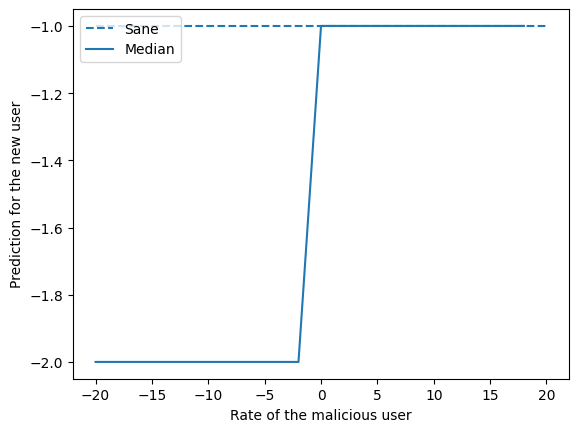

In [28]:
compute_plot_median(sane_rates2, user_unknown2, malicious2, 2, lower_threshold=0.3)

# Weighted QrMed

In [29]:
from scipy.optimize import minimize

In [52]:

def pipeline_QrwMed(item_nb, base_rates, user_unknown, reg=1.0):
    user_sim = create_sim(user_unknown, base_rates)

    # Zip weights and rates
    weights_rates = np.stack([user_sim, base_rates[:,item_nb]], axis=1)

    # Inverse rates and weights for negative weights
    weights_rates = np.apply_along_axis(lambda arr: arr if arr[0] >= 0 else -arr, 1, weights_rates)

    def QrwMed(x, weights_rates, reg):
        acc = 0.0
        for weight_rate in weights_rates:
            acc += weight_rate[0]*np.abs(weight_rate[1]-x)

        return acc + (reg * x**2)

    return minimize(QrwMed, np.array([0]), (weights_rates, reg)).x[0]

def compute_plot_QrwMed(sane_rates, user_unknown, malicious, item_nb, reg=1.0, range=20, ax=None):
    final_rate_qrmed = np.array([])
    mal_vals_to_test = np.arange(-range, range, int(range/10))

    sane_prediction = pipeline_QrwMed(item_nb, np.array(sane_rates), user_unknown, reg)

    for mal_rate in mal_vals_to_test:
        malicious[item_nb] = mal_rate
        base_rates = np.vstack([sane_rates, malicious])

        curr_rate_qrmed = pipeline_QrwMed(item_nb, base_rates, user_unknown, reg)
        final_rate_qrmed = np.append(final_rate_qrmed, curr_rate_qrmed)

        print(f'For mal_rate: {mal_rate}, curr_rate_median: {curr_rate_qrmed}')
        print('-------------------------------------')

    if ax is not None:
        ax.hlines(sane_prediction, -range, range, label='Sane pred', linestyles='dashed')
        ax.plot(mal_vals_to_test, final_rate_qrmed, label='QrMed')
        ax.set_xlabel('Rate of the malicious user')
        ax.set_ylabel('Prediction for the new user')
        ax.set_title(f'Reg = {reg}')
    else:
        plt.hlines(sane_prediction, -range, range, label='Sane pred', linestyles='dashed')
        plt.plot(mal_vals_to_test, final_rate_qrmed, label='QrMed')
        plt.xlabel('Rate of the malicious user')
        plt.ylabel('Prediction for the new user')
        plt.legend()
        plt.show()

For mal_rate: -20, curr_rate_median: -2.241912147904721
-------------------------------------
For mal_rate: -18, curr_rate_median: -2.241912147904721
-------------------------------------
For mal_rate: -16, curr_rate_median: -2.2419126909165517
-------------------------------------
For mal_rate: -14, curr_rate_median: -2.2419131627115534
-------------------------------------
For mal_rate: -12, curr_rate_median: -2.2419131627115534
-------------------------------------
For mal_rate: -10, curr_rate_median: -2.2419125953817183
-------------------------------------
For mal_rate: -8, curr_rate_median: -2.2419123594823755
-------------------------------------
For mal_rate: -6, curr_rate_median: -2.2419123594823755
-------------------------------------
For mal_rate: -4, curr_rate_median: -2.2419123594823755
-------------------------------------
For mal_rate: -2, curr_rate_median: -2.0000000079879827
-------------------------------------
For mal_rate: 0, curr_rate_median: -2.000000000284956
--

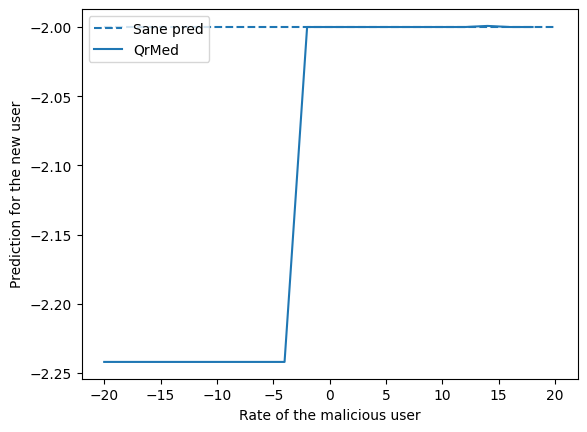

In [31]:
compute_plot_QrwMed(sane_rates, user_unknown, malicious, 5, 0.5)

For mal_rate: -20, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -18, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -16, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -14, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -12, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -10, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -8, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -6, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -4, curr_rate_median: -1.0
-------------------------------------
For mal_rate: -2, curr_rate_median: -1.0
-------------------------------------
For mal_rate: 0, curr_rate_median: 0.0
-------------------------------------
For mal_rate: 2, curr_rate_median: 1.0
-------------------------------------
For mal_rate: 4, curr_rate_median: 1.0
-----------

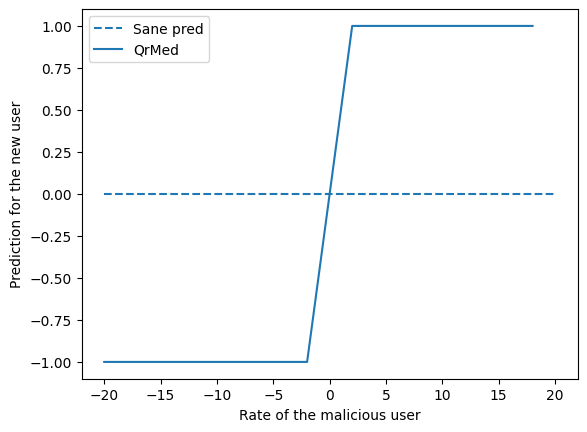

In [32]:
compute_plot_QrwMed(sane_rates2, user_unknown2, malicious2, 2, 0.5)

# Normal distribution
Simulating common case with normal distribution:
- First half of users has voted ~-0.5 for the first half of items and ~0.5 for the second half of items
- Second half of users is the inverse
- The new user is similar to the first group

In [7]:
from numpy.random import normal
from numpy.random import shuffle

n_users = 100
n_items = 40

ratings_normal = normal(0, 0.25, size=(n_users, n_items))

ratings_normal[int(n_users / 2):, int(n_items / 2):] -= 0.5
ratings_normal[int(n_users / 2):, :int(n_items / 2)] += 0.5
ratings_normal[:int(n_users / 2), int(n_items / 2):] += 0.5
ratings_normal[:int(n_users / 2), :int(n_items / 2)] -= 0.5
ratings_normal

array([[-0.52309754, -0.31642861, -0.85972051, ...,  0.33652375,
         0.481763  ,  0.64798438],
       [-0.28559901, -0.7985446 , -0.02461482, ...,  0.56318744,
         0.10972031,  0.76006338],
       [-0.82314543, -0.8138457 , -0.53620303, ...,  0.4058889 ,
        -0.06508502,  0.29239315],
       ...,
       [ 0.80310194,  0.16502722,  1.01471612, ...,  0.0173862 ,
        -0.6909133 , -0.71111485],
       [ 0.84448706,  0.67406256,  0.43503295, ..., -0.4754501 ,
        -0.9748568 , -0.57316909],
       [ 0.27113393, -0.14744604,  0.35944869, ..., -0.51483436,
        -0.66853558, -0.72897999]])

In [76]:
new_user_normal = normal(0, 0.25, size=n_items)
new_user_normal[int(n_items / 2):] -= 0.5
new_user_normal[:int(n_items / 2)] += 0.5
print(f"Expected value: {new_user_normal[-1]}")
new_user_normal[-1] -= np.nan
new_user_normal

Expected value: -0.32520061136914463


array([ 0.98156306,  0.57685531,  0.47689387,  0.23089961,  0.61500472,
        0.66152461,  0.62890738,  0.46893701,  0.0926621 ,  0.45049639,
        0.9318444 ,  0.61315919,  0.54312046,  0.48298725,  0.29837238,
        0.94570675,  0.61377575,  0.31326832,  0.40189701,  0.89713411,
       -0.42960013, -0.24601742, -0.46179827, -0.67882036, -0.28294759,
       -0.73426585, -0.53693467, -0.58687912, -0.60877813, -0.11215054,
       -0.37897657, -0.52945547, -0.56766451, -0.29896038, -0.4380699 ,
       -0.38546687, -0.15086453, -0.90938159, -0.62698006,         nan])

In [77]:
malicious_normal = new_user_normal.copy()
#malicious[-1] = 1000000
malicious_normal

array([ 0.98156306,  0.57685531,  0.47689387,  0.23089961,  0.61500472,
        0.66152461,  0.62890738,  0.46893701,  0.0926621 ,  0.45049639,
        0.9318444 ,  0.61315919,  0.54312046,  0.48298725,  0.29837238,
        0.94570675,  0.61377575,  0.31326832,  0.40189701,  0.89713411,
       -0.42960013, -0.24601742, -0.46179827, -0.67882036, -0.28294759,
       -0.73426585, -0.53693467, -0.58687912, -0.60877813, -0.11215054,
       -0.37897657, -0.52945547, -0.56766451, -0.29896038, -0.4380699 ,
       -0.38546687, -0.15086453, -0.90938159, -0.62698006,         nan])

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

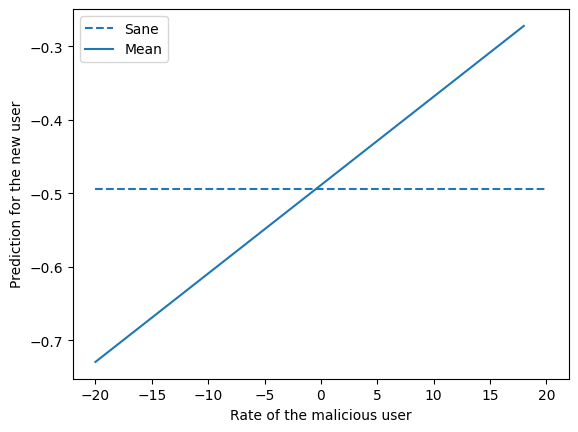

In [78]:
compute_plot_mean(ratings_normal, new_user_normal, malicious_normal, -1)

weights_rates before inversion: [[-0.82574682  0.48783867]
 [-0.83012672  0.57459086]
 [-0.82218668  0.73928094]
 [-0.87756558  0.63618936]
 [-0.78971918  0.47544924]
 [-0.84194644  0.11444678]
 [-0.88122887  0.88205869]
 [-0.86634464  0.12713858]
 [-0.7673466   0.41908008]
 [-0.78218621  0.55539515]
 [-0.80757853  0.25831674]
 [-0.72809839  0.11823418]
 [-0.78339675  0.7253815 ]
 [-0.85145818  0.7186608 ]
 [-0.80095282  0.55351494]
 [-0.78791481  0.68305186]
 [-0.80481798  0.0214879 ]
 [-0.91423377  0.68908066]
 [-0.85241562  0.26631497]
 [-0.80482887  0.62975285]
 [-0.80869986  0.56137332]
 [-0.84683291  0.44101894]
 [-0.74974195  0.36761654]
 [-0.83116622  0.48923959]
 [-0.79968458  0.76891143]
 [-0.81585473  0.47977449]
 [-0.83898606  0.10402163]
 [-0.77176191  0.41986336]
 [-0.84268664  0.42175973]
 [-0.84911879  0.4457985 ]
 [-0.8434036   0.3351727 ]
 [-0.7998402   0.15256521]
 [-0.87070876  0.70014916]
 [-0.89554287  0.763479  ]
 [-0.81664243  0.2418615 ]
 [-0.78867653  0.507552

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

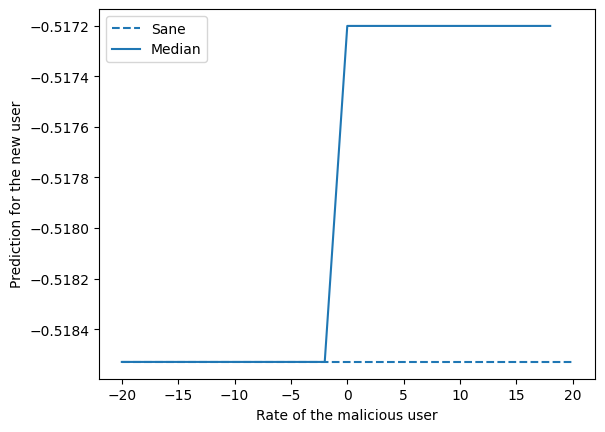

In [79]:
compute_plot_median(ratings_normal, new_user_normal, malicious_normal, -1)

weights_rates before inversion: [[-0.82574682  0.48783867]
 [-0.83012672  0.57459086]
 [-0.82218668  0.73928094]
 [-0.87756558  0.63618936]
 [-0.78971918  0.47544924]
 [-0.84194644  0.11444678]
 [-0.88122887  0.88205869]
 [-0.86634464  0.12713858]
 [-0.7673466   0.41908008]
 [-0.78218621  0.55539515]
 [-0.80757853  0.25831674]
 [-0.72809839  0.11823418]
 [-0.78339675  0.7253815 ]
 [-0.85145818  0.7186608 ]
 [-0.80095282  0.55351494]
 [-0.78791481  0.68305186]
 [-0.80481798  0.0214879 ]
 [-0.91423377  0.68908066]
 [-0.85241562  0.26631497]
 [-0.80482887  0.62975285]
 [-0.80869986  0.56137332]
 [-0.84683291  0.44101894]
 [-0.74974195  0.36761654]
 [-0.83116622  0.48923959]
 [-0.79968458  0.76891143]
 [-0.81585473  0.47977449]
 [-0.83898606  0.10402163]
 [-0.77176191  0.41986336]
 [-0.84268664  0.42175973]
 [-0.84911879  0.4457985 ]
 [-0.8434036   0.3351727 ]
 [-0.7998402   0.15256521]
 [-0.87070876  0.70014916]
 [-0.89554287  0.763479  ]
 [-0.81664243  0.2418615 ]
 [-0.78867653  0.507552

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

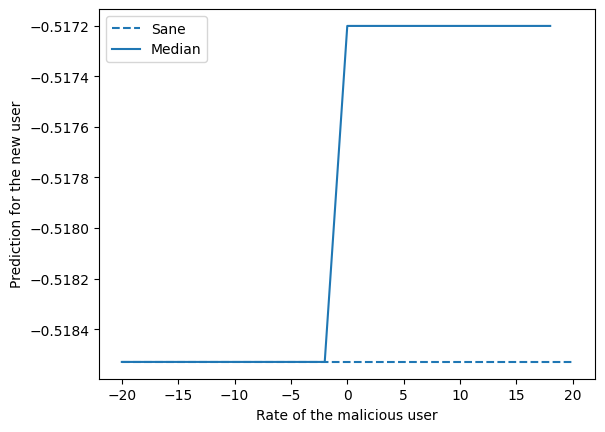

In [80]:
compute_plot_median(ratings_normal, new_user_normal, malicious_normal, -1, 0.2)

For mal_rate: -20, curr_rate_median: -0.4645799197981692
-------------------------------------
For mal_rate: -18, curr_rate_median: -0.4645799197981692
-------------------------------------
For mal_rate: -16, curr_rate_median: -0.4645799058079281
-------------------------------------
For mal_rate: -14, curr_rate_median: -0.4645799058079281
-------------------------------------
For mal_rate: -12, curr_rate_median: -0.4645799058079281
-------------------------------------
For mal_rate: -10, curr_rate_median: -0.4645799058079281
-------------------------------------
For mal_rate: -8, curr_rate_median: -0.4645799058919751
-------------------------------------
For mal_rate: -6, curr_rate_median: -0.4645799058919751
-------------------------------------
For mal_rate: -4, curr_rate_median: -0.4645799058919751
-------------------------------------
For mal_rate: -2, curr_rate_median: -0.46457990871742005
-------------------------------------
For mal_rate: 0, curr_rate_median: -0.459151862194502

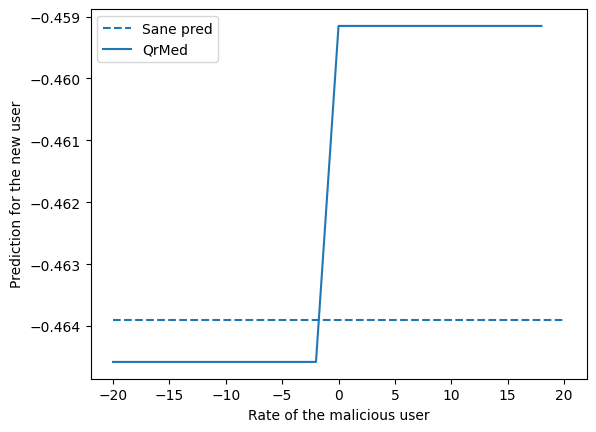

In [61]:
compute_plot_QrwMed(ratings_normal, new_user_normal, malicious_normal, -1, 1.0, range=20)

### Effect of regularizer term on the prediction

For mal_rate: -20, curr_rate_median: -0.5225172289903545
-------------------------------------
For mal_rate: -18, curr_rate_median: -0.5225172289903545
-------------------------------------
For mal_rate: -16, curr_rate_median: -0.5225172292447741
-------------------------------------
For mal_rate: -14, curr_rate_median: -0.5225172292447741
-------------------------------------
For mal_rate: -12, curr_rate_median: -0.5185286339981542
-------------------------------------
For mal_rate: -10, curr_rate_median: -0.5225172348225864
-------------------------------------
For mal_rate: -8, curr_rate_median: -0.5225172348225859
-------------------------------------
For mal_rate: -6, curr_rate_median: -0.5185286338380312
-------------------------------------
For mal_rate: -4, curr_rate_median: -0.5185286338345477
-------------------------------------
For mal_rate: -2, curr_rate_median: -0.5185286334883649
-------------------------------------
For mal_rate: 0, curr_rate_median: -0.5172015349255001

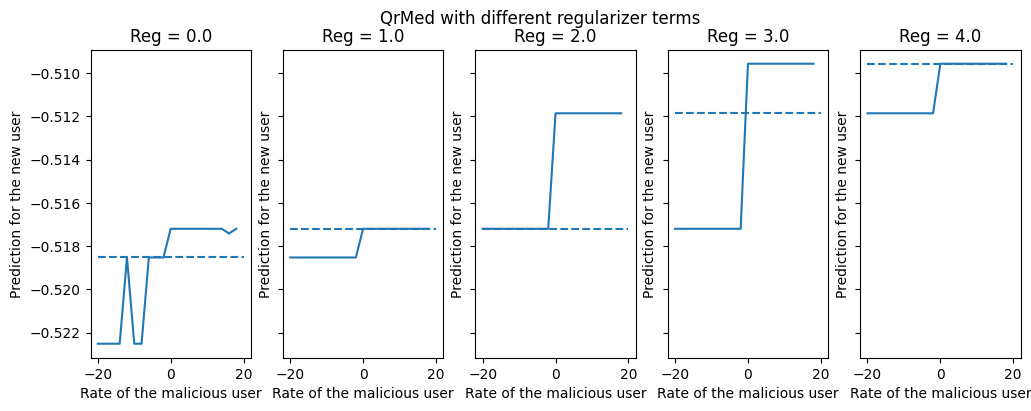

In [81]:
reg_range = 4.0
number_of_plots = 5

fig, axs = plt.subplots(1, number_of_plots, sharey='all', figsize=(12, 4))
step = reg_range/(number_of_plots-1)
for idx, reg in enumerate(np.arange(0, reg_range+step, step)):
    compute_plot_QrwMed(ratings_normal, new_user_normal, malicious_normal, -1, reg=reg, ax=axs[idx])

fig.suptitle('QrMed with different regularizer terms')
plt.show()

# Normal distribution approching edge case
We are simulating, using normal distributions, the case where no other user is similar nor inversely similar to the new user (sim ≃ 0) expect the adversary where sim = 1

In [102]:
from numpy.random import normal

n_users = 100
n_items = 41

ratings_normal_edge = normal(0, 0, size=(n_users, n_items))

ratings_normal_edge[int(n_users / 2):, int(n_items / 2):] -= 0.5
ratings_normal_edge[int(n_users / 2):, :int(n_items / 2)] += 0.5
ratings_normal_edge[:int(n_users / 2), int(n_items / 2):] += 0.5
ratings_normal_edge[:int(n_users / 2), :int(n_items / 2)] -= 0.5


new_user_normal_edge = normal(0, 0, size=n_items)
new_user_normal_edge += 0.5
print(f'Expected prediction: {new_user_normal_edge[-1]}')
new_user_normal_edge[-1] -= np.nan

malicious_normal_edge = new_user_normal_edge.copy()
#malicious[-1] = 10

ratings_normal_edge

Expected prediction: 0.5


array([[-0.5, -0.5, -0.5, ...,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, ...,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, ...,  0.5,  0.5,  0.5],
       ...,
       [ 0.5,  0.5,  0.5, ..., -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5, ..., -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5, ..., -0.5, -0.5, -0.5]])

In [103]:
new_user_normal_edge

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, nan])

/tmp/ipykernel_15476/940821144.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return rate/sum_sim
/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

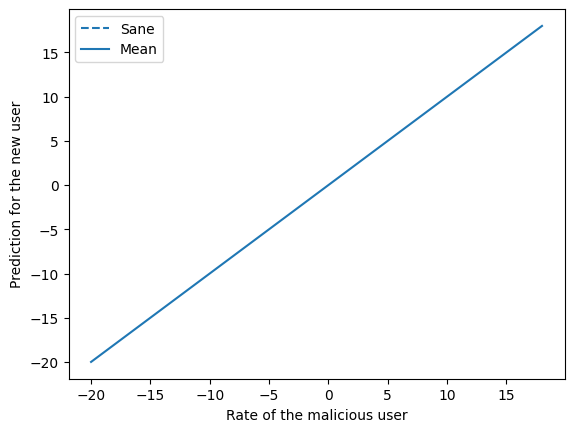

In [104]:
compute_plot_mean(ratings_normal_edge, new_user_normal_edge, malicious_normal_edge, -1)


weights_rates before inversion: [[ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.   0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0.  -0.5]
 [ 0. 

/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

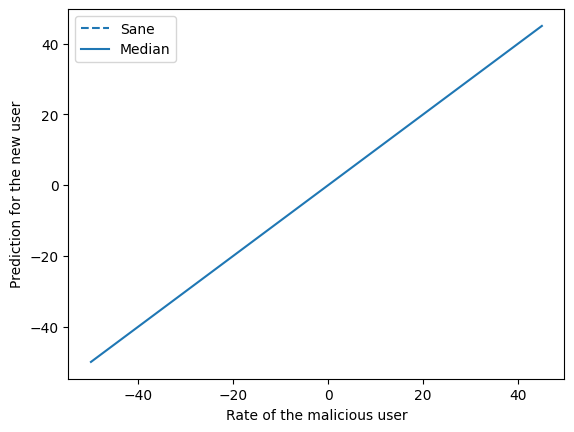

In [105]:
compute_plot_median(ratings_normal_edge, new_user_normal_edge, malicious_normal_edge, -1, range=50)

weights_rates before inversion: [[ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2  0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2 -0.5]
 [ 0.2

<module 'matplotlib.pyplot' from '/home/benjamin/Anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

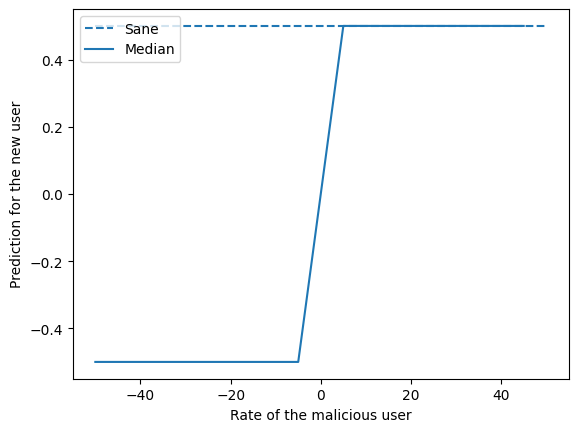

In [106]:
compute_plot_median(ratings_normal_edge, new_user_normal_edge, malicious_normal_edge, -1, 0.2, range=50)

For mal_rate: -20, curr_rate_median: -0.125
-------------------------------------
For mal_rate: -18, curr_rate_median: -0.125
-------------------------------------
For mal_rate: -16, curr_rate_median: -0.125
-------------------------------------
For mal_rate: -14, curr_rate_median: -0.125
-------------------------------------
For mal_rate: -12, curr_rate_median: -0.12499999697320155
-------------------------------------
For mal_rate: -10, curr_rate_median: -0.12500000512227483
-------------------------------------
For mal_rate: -8, curr_rate_median: -0.12500000512227483
-------------------------------------
For mal_rate: -6, curr_rate_median: -0.1250000040745362
-------------------------------------
For mal_rate: -4, curr_rate_median: -0.12500000407453624
-------------------------------------
For mal_rate: -2, curr_rate_median: -0.1250000025611372
-------------------------------------
For mal_rate: 0, curr_rate_median: 0.0
-------------------------------------
For mal_rate: 2, curr_rat

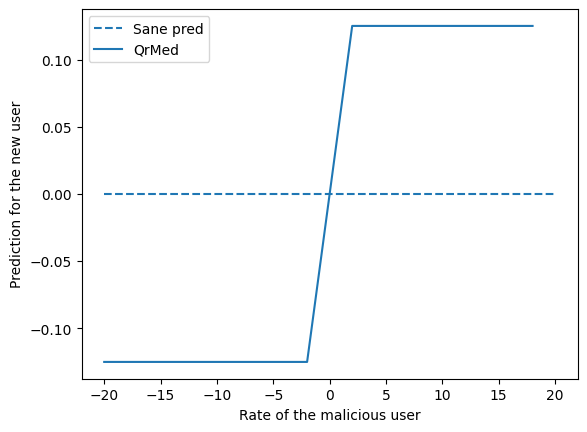

In [107]:
compute_plot_QrwMed(ratings_normal_edge, new_user_normal_edge, malicious_normal_edge, -1, reg=4.0)


### Effect of the regularizer term on the edge case

For mal_rate: -20, curr_rate_median: -20.00000000745058
-------------------------------------
For mal_rate: -18, curr_rate_median: -18.000000003548738
-------------------------------------
For mal_rate: -16, curr_rate_median: -16.00000000745058
-------------------------------------
For mal_rate: -14, curr_rate_median: -14.000000002073069
-------------------------------------
For mal_rate: -12, curr_rate_median: -12.000000005325695
-------------------------------------
For mal_rate: -10, curr_rate_median: -10.000000003341171
-------------------------------------
For mal_rate: -8, curr_rate_median: -8.000000002377027
-------------------------------------
For mal_rate: -6, curr_rate_median: -6.000000007450581
-------------------------------------
For mal_rate: -4, curr_rate_median: -4.000000007055452
-------------------------------------
For mal_rate: -2, curr_rate_median: -2.0000000020730684
-------------------------------------
For mal_rate: 0, curr_rate_median: 0.0
--------------------

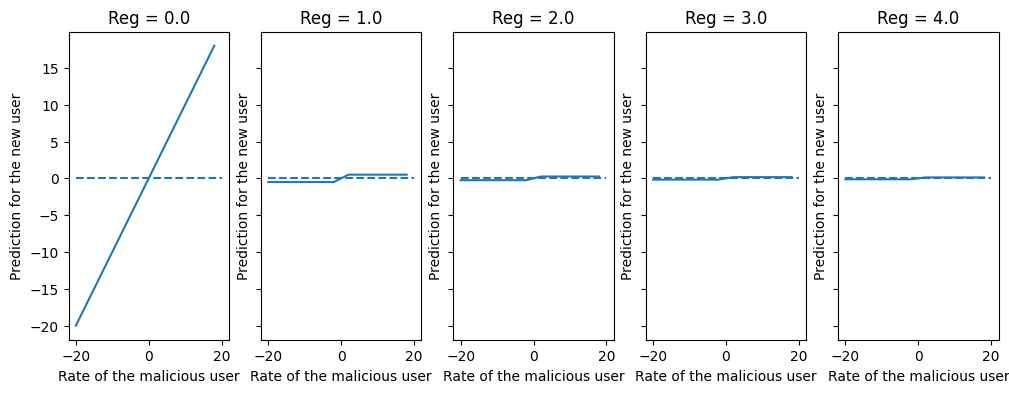

In [108]:
reg_range = 4.0
number_of_plots = 5

fig, axs = plt.subplots(1, number_of_plots, sharey='all', figsize=(12, 4))
step = reg_range/(number_of_plots-1)
for idx, reg in enumerate(np.arange(0, reg_range+step, step)):
    compute_plot_QrwMed(ratings_normal_edge, new_user_normal_edge, malicious_normal_edge, -1, reg=reg, ax=axs[idx])

plt.show()

### Threshold median edge case

In [48]:
'''
n_users = 20
n_items = 40

ratings_normal = normal(0, 1, size=(n_users, n_items))

#ratings[:19, :int(n_items / 2)] -= 60
ratings_normal[19:, int(n_items / 2):] += 60


new_user_normal = normal(0, 1, size=n_items)
new_user_normal[int(n_items / 2):] += 60
new_user_normal[-1] -= np.nan

malicious_normal = new_user_normal.copy()
malicious_normal[-1] = 100000000

ratings_normal
'''

'\nn_users = 20\nn_items = 40\n\nratings_normal = normal(0, 1, size=(n_users, n_items))\n\n#ratings[:19, :int(n_items / 2)] -= 60\nratings_normal[19:, int(n_items / 2):] += 60\n\n\nnew_user_normal = normal(0, 1, size=n_items)\nnew_user_normal[int(n_items / 2):] += 60\nnew_user_normal[-1] -= np.nan\n\nmalicious_normal = new_user_normal.copy()\nmalicious_normal[-1] = 100000000\n\nratings_normal\n'

In [49]:
#new_user_normal

In [50]:
#malicious_normal

In [51]:
#compute_plot_median(ratings_normal, new_user_normal, malicious_normal, -1, 0.15, range=100)

# Matrix factorization set generation

In [2]:
from Syn_data_gen import generate_synthetic_ratings

ratings_df, long_df, meta = generate_synthetic_ratings(
    n_users=200,
    n_items=100,
    n_factors=6,
    n_groups=5,
    group_strength=0.3,
    user_noise=0.15,
    item_scale=1.0,
    global_mean=0.0,
    noise_std=0.1,
    missing_prob=0.25,
    rating_min=None,
    rating_max=None,
    random_seed=2024
)

print("Generated matrix shape:", ratings_df.shape)

ratings_df

Generated matrix shape: (200, 100)


,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_90,item_91,item_92,item_93,item_94,item_95,item_96,item_97,item_98,item_99
user_0,NaN,1.205521,NaN,NaN,2.661520,1.477381,-3.373922,NaN,NaN,-3.437698,...,-2.463237,-0.059425,0.715998,NaN,-2.514926,6.281469,-2.886025,-4.569747,-0.532242,-3.362230
user_1,-2.662075,-0.769733,NaN,NaN,NaN,-2.298515,NaN,2.569000,-4.381570,NaN,...,NaN,NaN,-0.655006,NaN,NaN,1.407270,-1.747853,0.547784,-0.453941,-2.447651
user_2,NaN,0.938729,-2.739488,-2.111751,-2.663067,3.319380,1.110878,2.596868,4.007355,-3.256645,...,-1.860785,0.599340,NaN,-2.268153,-2.011159,NaN,NaN,0.049062,0.077387,0.759495
user_3,NaN,-1.696783,3.426101,1.504833,0.648551,-2.125624,-2.882025,-1.552333,NaN,0.942422,...,1.936033,0.141715,-0.494510,2.205103,0.176655,-0.101887,-1.233041,NaN,NaN,-0.992998
user_4,2.643154,1.000642,NaN,NaN,-1.756368,NaN,-1.607016,-3.843447,0.189934,0.343454,...,NaN,1.713425,1.109609,0.945990,NaN,0.033590,0.190965,1.317906,NaN,0.557250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_195,3.386857,1.099681,3.176271,NaN,NaN,1.616911,-4.154084,9.616594,7.470174,NaN,...,-2.511830,NaN,0.514316,2.558088,NaN,7.231726,NaN,-5.472893,-0.813424,-4.360821
user_196,2.712338,NaN,1.643118,NaN,NaN,-3.196202,-2.327175,-1.656884,-0.167320,0.811532,...,1.111029,NaN,-0.182725,1.900041,-1.117400,0.390041,NaN,0.043723,NaN,-0.096411
user_197,-2.173504,NaN,-8.954208,-0.551272,-9.420455,NaN,5.030191,NaN,NaN,-0.105752,...,-1.581196,3.895695,-0.058228,-4.913600,-2.557432,-4.643773,4.414724,NaN,2.698044,5.813993
user_198,NaN,2.557938,-2.023228,-2.811338,-2.533013,0.725128,NaN,2.963681,2.379117,-1.485628,...,NaN,NaN,0.820459,NaN,NaN,0.682028,NaN,NaN,1.342782,NaN


In [8]:
import numpy as np

def add_attacker(ratings, nb_attackers=1, note_attackers=10000):
    ratings = ratings.copy()
    ratings.iloc[0, -1] = np.nan
    attacker = ratings.iloc[0].copy()
    attacker.iloc[-1] = note_attackers

    ratings = np.vstack([ratings, [attacker for _ in range(nb_attackers)]])
    return ratings

In [10]:
ratings_att = add_attacker(ratings_df)

# Use delta as metrix
Compare delta of attacker and correctness without him.

In [ ]:
def compute_pred(ratings):
    create_sim(ratings)
